In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import h5py # pour gérer les formats de données utilisés ici
from scipy.signal import welch, spectrogram
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/TP3
!ls -lh

Mounted at /content/drive
/content/drive/MyDrive/TP3
total 786M
-rw------- 1 root root  44K Nov 21 14:00 dlts_tp3.ipynb
-rw------- 1 root root 3.4K Nov 21 13:50 dumb_model_weights.pth
-rw------- 1 root root  59K Nov 21 13:51 model_weights.pth
-rw------- 1 root root 694K Nov 21 13:57 model_weights_RNN.pth
-rw------- 1 root root 3.2M Nov  4 17:04 samples.hdf5
-rw------- 1 root root 157M Nov  4 17:04 test.hdf5
-rw------- 1 root root 469M Nov  4 17:04 train.hdf5
-rw------- 1 root root  44K Nov 11 23:40 training_losses.png
-rw------- 1 root root 157M Nov  4 17:04 validation.hdf5


# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

2 séances de TP sur ce sujet : le 5 novembre (1h00), le 12 novembre (3h).
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br>
Deadline pour le rendu du TP: 26 novembre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [3]:
data_path = './samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [4]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

samples = 200
signal length = 2048
classes = 6


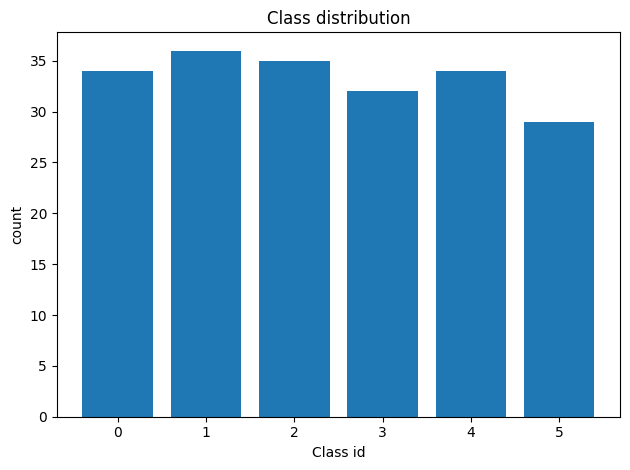

min(snr) = 0, max(snr) = 30


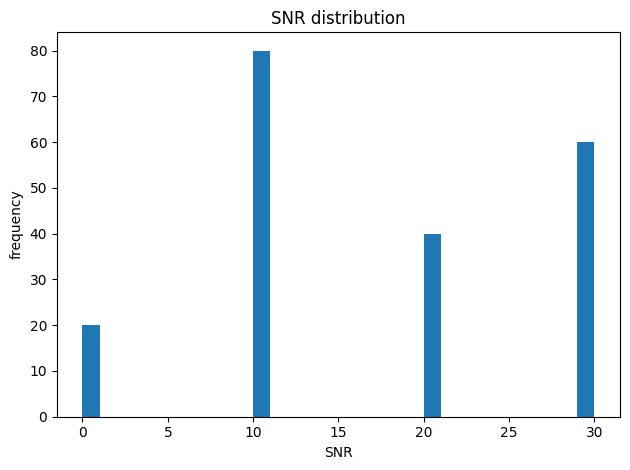

In [5]:
"""observez leur taille"""
N = signals.shape[0]
L = signals.shape[1]
n_classes = len(np.unique(labels_id))

print(f"samples = {N}")
print(f"signal length = {L}")
print(f"classes = {n_classes}")

"""la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement"""
unique_labels, counts = np.unique(labels_id, return_counts=True)

# Class distribution
plt.figure()
plt.bar(unique_labels.astype(str), counts)
plt.title("Class distribution")
plt.xlabel("Class id")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# SNR distribution
plt.figure()
print(f"min(snr) = {min(snr)}, max(snr) = {max(snr)}")
plt.hist(snr, bins=30)
plt.title("SNR distribution")
plt.xlabel("SNR")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

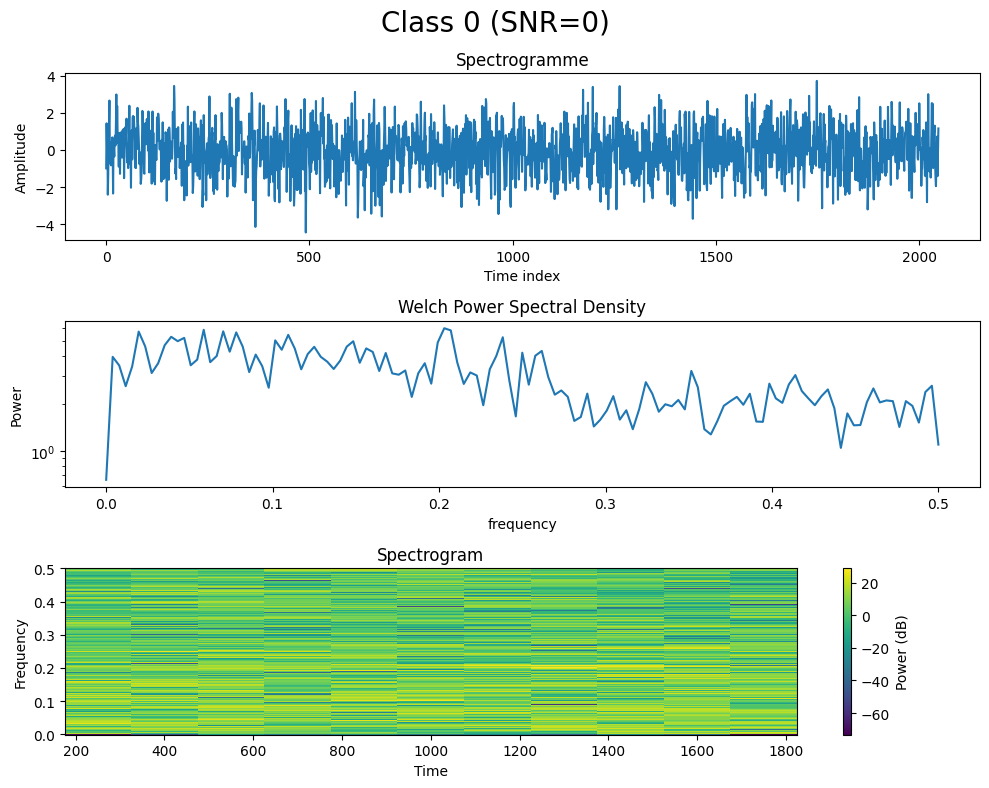

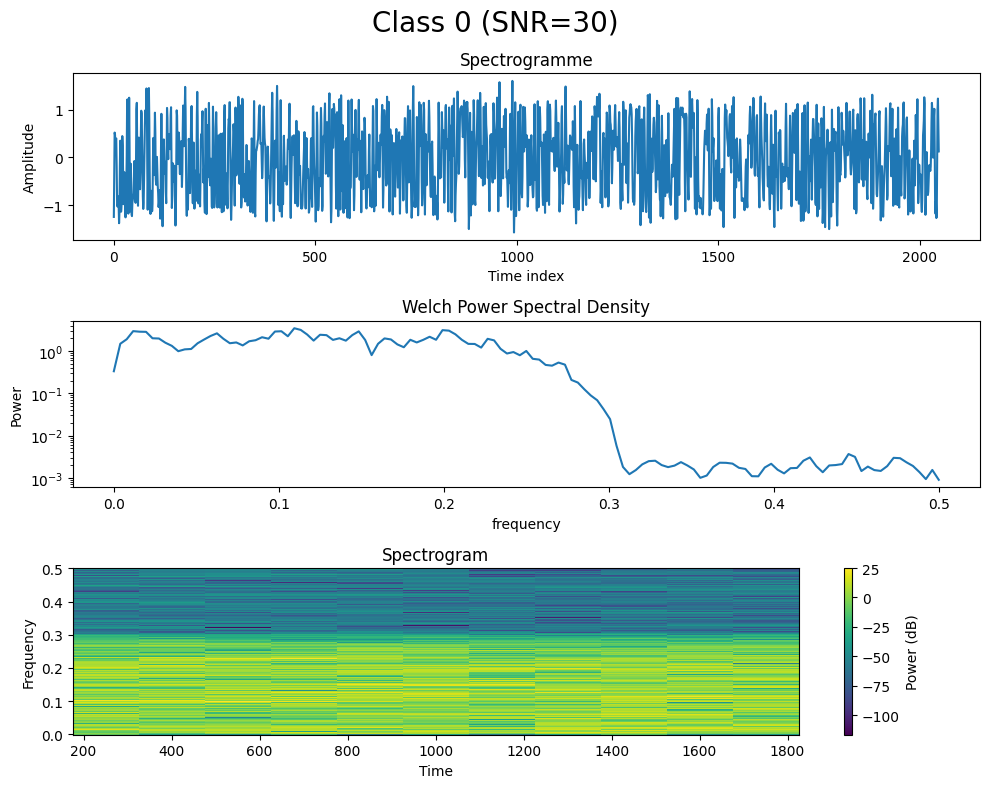

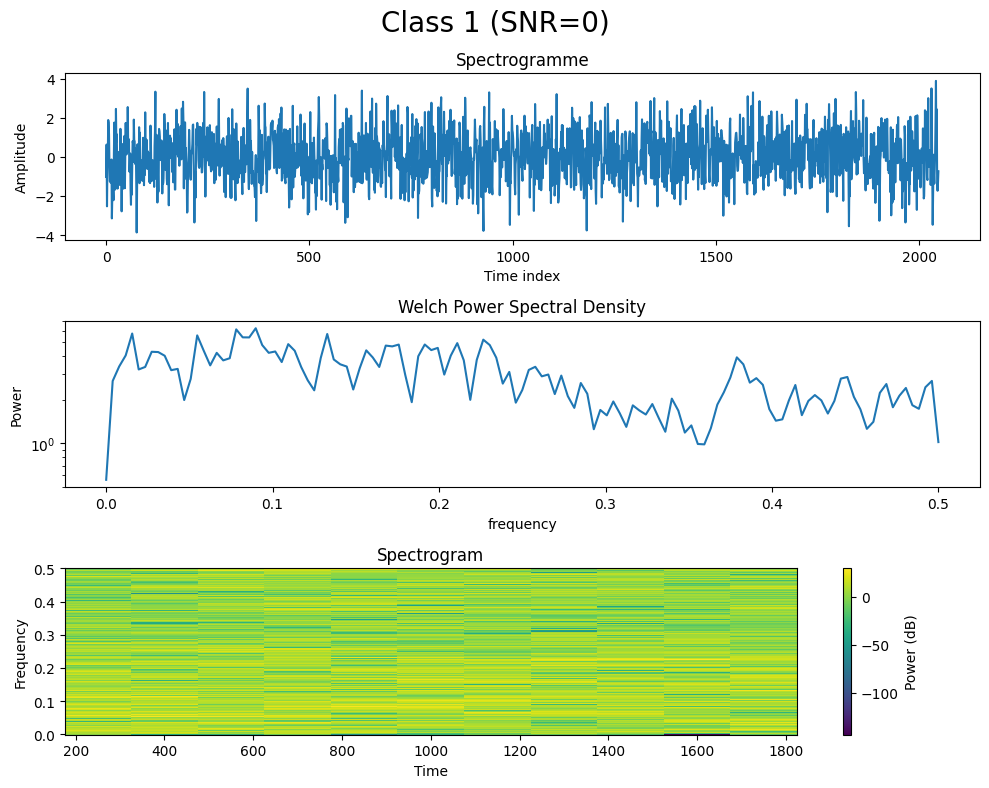

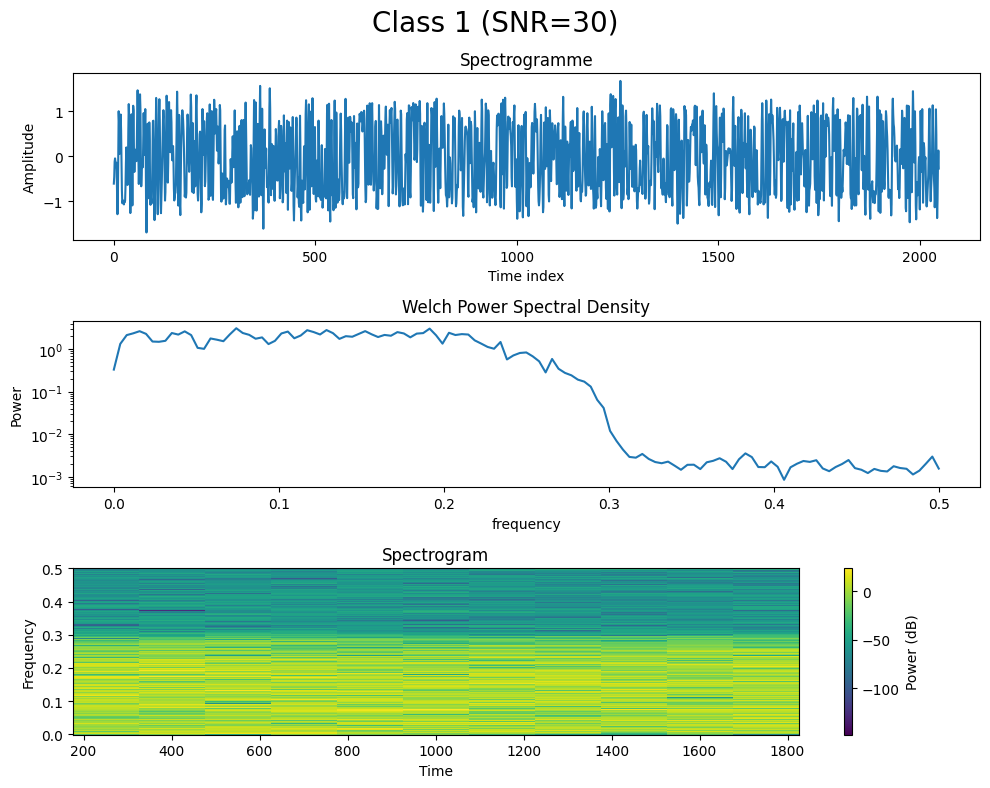

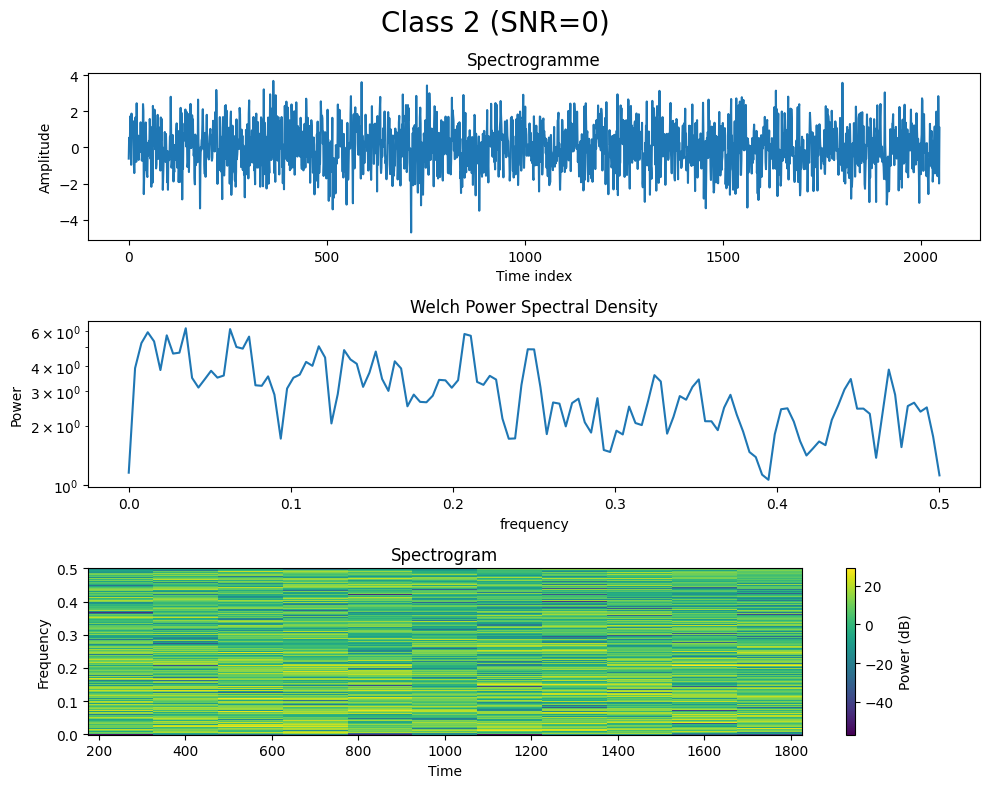

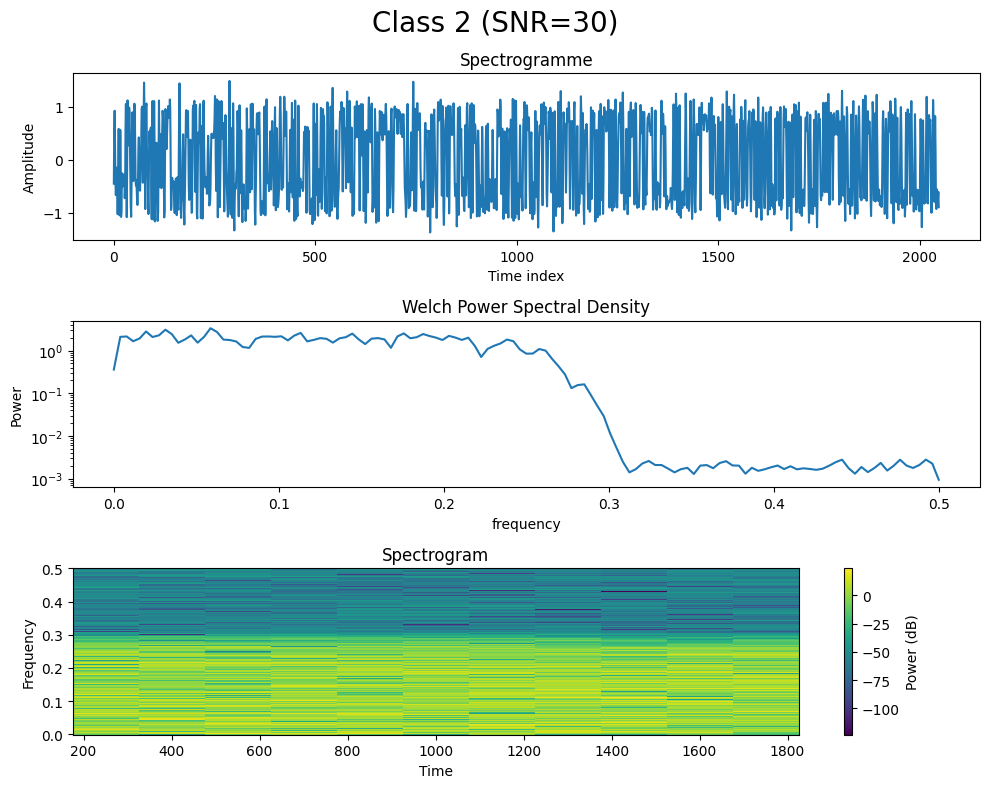

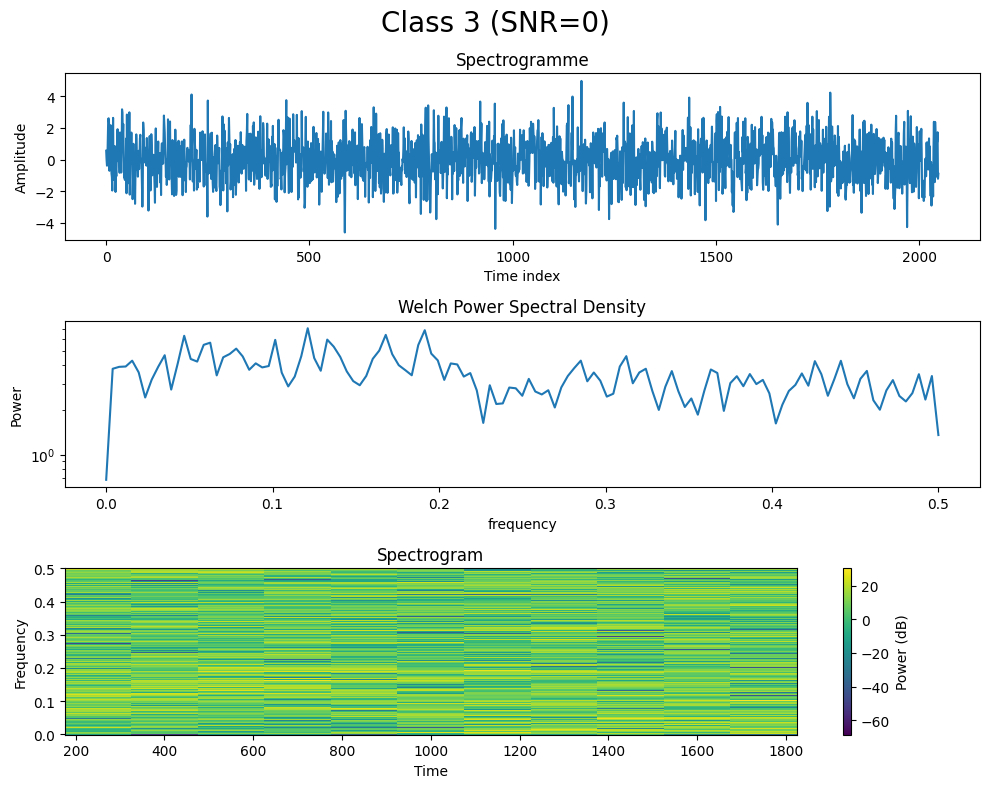

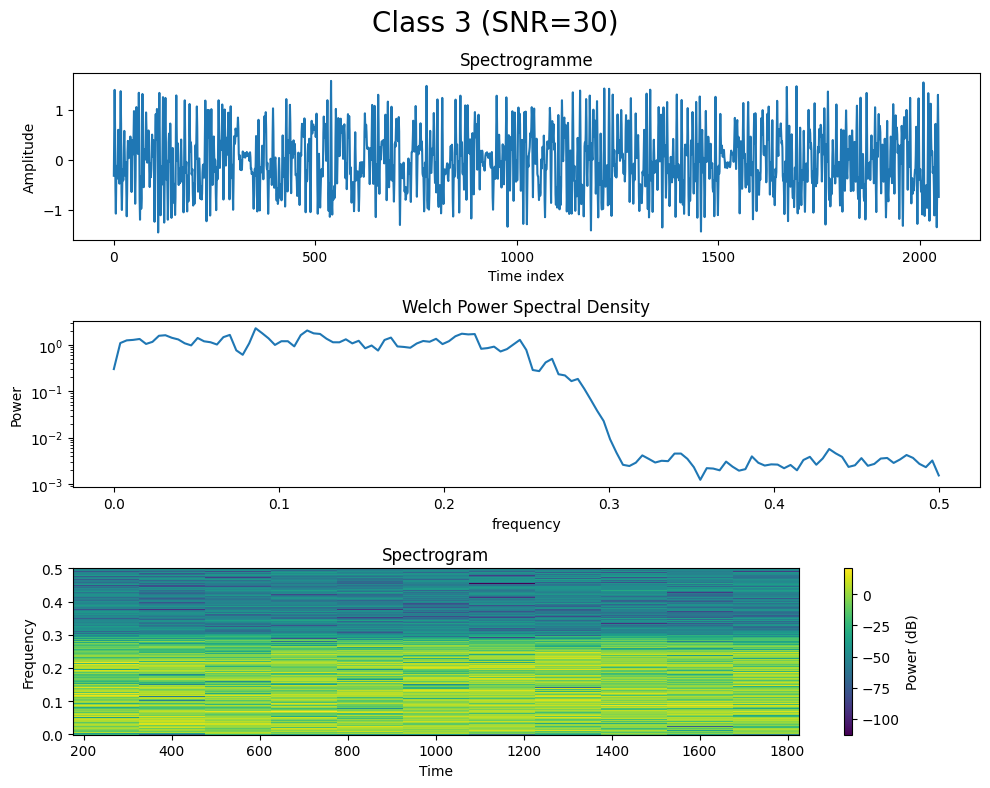

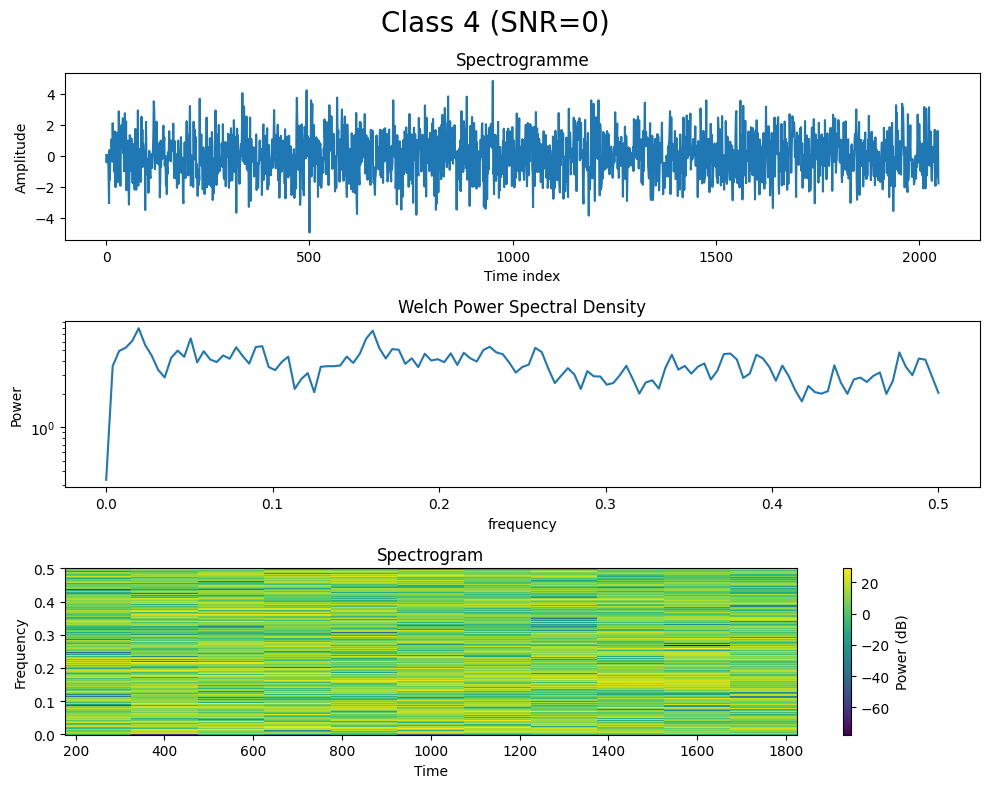

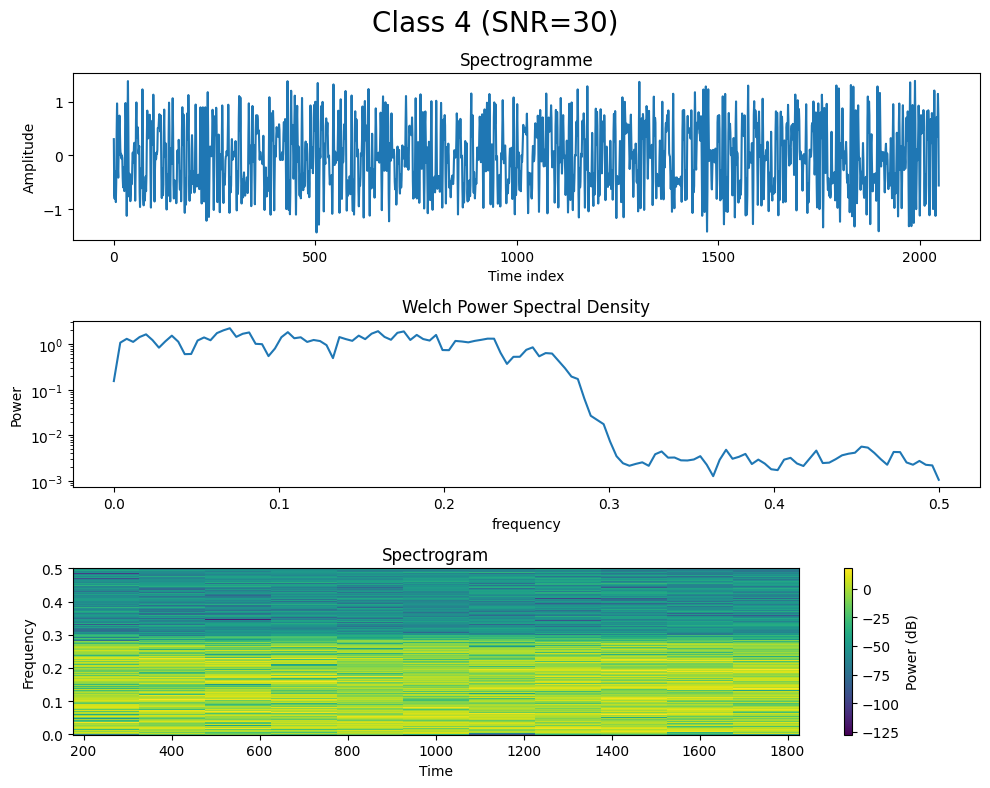

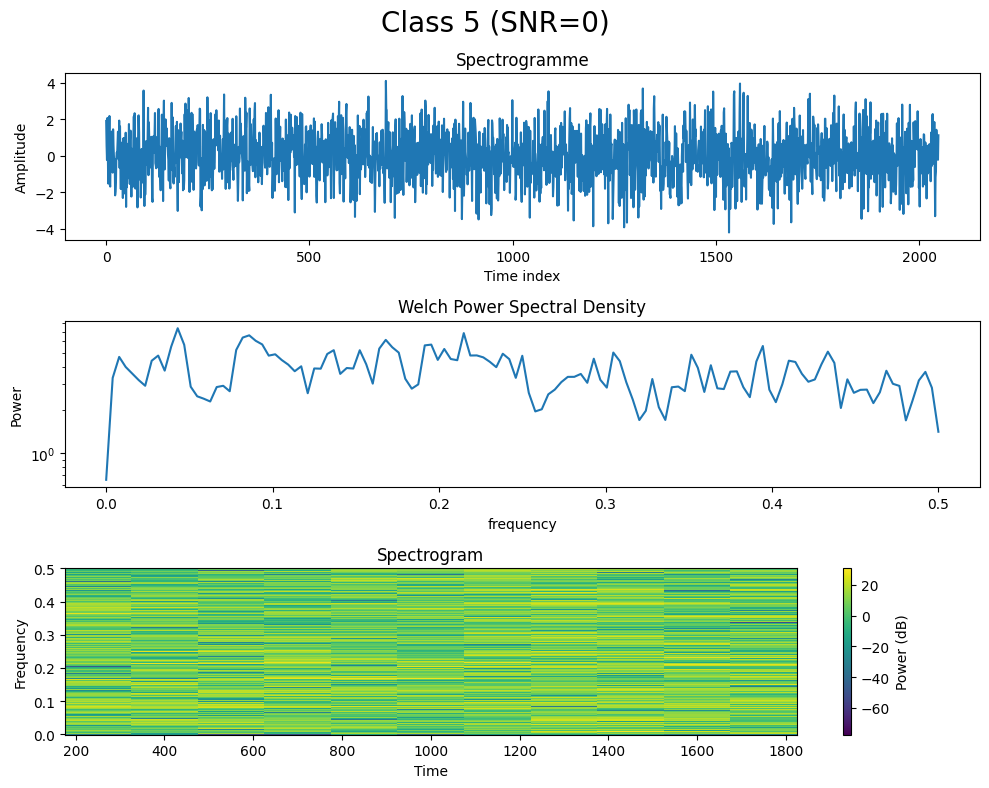

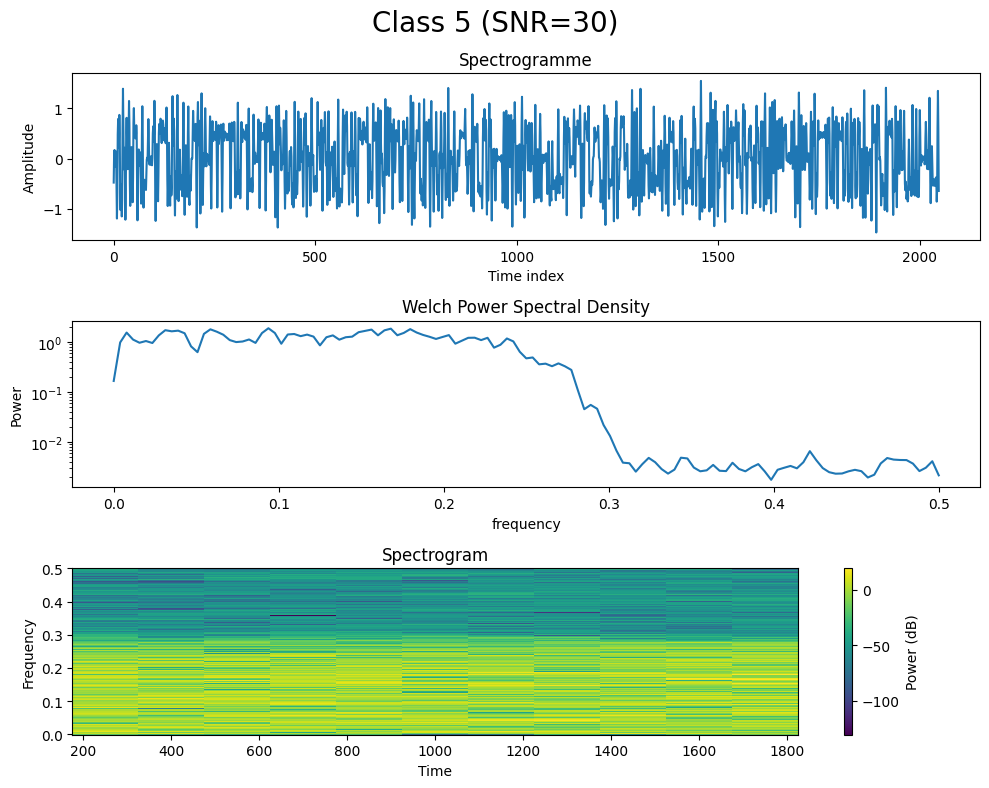

In [6]:
"""visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez"""
def plot_signal(idx, class_id, snr_value):
    y = signals[idx]

    if y.ndim == 2:
        y = y[:, 1]
    x = np.arange(len(y))

    f_wel, wel = welch(y, fs=1.0)
    win_size = 500
    freq, time, Sxx = spectrogram(y, fs=1.0, nperseg=win_size, nfft=win_size, noverlap=0.7*win_size)

    fig, axes = plt.subplots(3, 1, figsize=(10, 8))

    axes[0].plot(x, y)
    axes[0].set_title(f"Spectrogramme")
    axes[0].set_xlabel("Time index")
    axes[0].set_ylabel("Amplitude")

    axes[1].semilogy(f_wel, wel)
    axes[1].set_title("Welch Power Spectral Density")
    axes[1].set_xlabel("frequency")
    axes[1].set_ylabel("Power")

    pcm = axes[2].pcolormesh(time, freq, 10 * np.log10(np.abs(Sxx)**2))
    axes[2].set_title("Spectrogram")
    axes[2].set_xlabel("Time")
    axes[2].set_ylabel("Frequency")
    fig.colorbar(pcm, ax=axes[2], label="Power (dB)")

    fig.suptitle(f"Class {class_id} (SNR={snr_value})", fontsize=20)
    plt.tight_layout()
    plt.show()

keys = [0,1,2,3,4,5] #Ou en fonction de SNR ? (30,20,10,0) and we check each class ?
for key in keys :
  idxs = np.where(labels_id == key)[0]
  low_snr_idx = idxs[np.argmin(snr[idxs])]
  high_snr_idx = idxs[np.argmax(snr[idxs])]
  plot_signal(low_snr_idx, key, snr[low_snr_idx])
  plot_signal(high_snr_idx, key, snr[high_snr_idx])

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        data = h5py.File(path_to_data , 'r')
        self.signals = np.array(data['signaux'])
        self.snr =  np.array(data['snr'])
        self.labels_id = np.array(data['labels'])
        #  (batch_size, channels, length) ： (N, L, 2)，to (N, 2, L)
        self.signals = np.transpose(self.signals, (0, 2, 1))

    def __len__(self):
        return len(self.labels_id)

    def __getitem__(self, i):
        x = torch.from_numpy(self.signals[i])
        y = torch.tensor(self.labels_id[i], dtype=torch.int64) #int need to be a tensor type too
        snr = torch.tensor(self.snr[i], dtype=torch.float32)
        return x, y, snr


Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [8]:
dataset = MyDataset(data_path)

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [9]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [10]:
for s in [10, 100, 1000]:
    dataloader = DataLoader(dataset, batch_size=s, shuffle=True)
    print(f"\nBatch size = {s}")
    for i, (x, y, snr) in enumerate(dataloader):
        print(f"Batch {i}: x -> {x.shape}, y -> {y.shape}, snr -> {snr.shape}")


Batch size = 10
Batch 0: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 1: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 2: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 3: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 4: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 5: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 6: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 7: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 8: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 9: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 10: x -> torch.Size([10, 2, 2048]), y -> torch.Size([10]), snr -> torch.Size([10])
Batch 11: x ->

## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [11]:
N_CHANNELS = 2
N_CLASSES = 6

class DumbModel(nn.Module):
    def __init__(self, in_channels, num_classes): #Definitions des couches
        super(DumbModel, self).__init__()

        # Couche de Pooling (Moyenne) sur la dimension temporelle : Réduit la dimension T à 1.
        # Entrée: [B, C, T] -> Sortie: [B, C, 1]
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Aplatir la dimension pour la couche lineaire
        # Entrée: [B, C, 1] -> Sortie: [B, C]
        self.flatten = nn.Flatten()

        # Couche linéaire : Passe des C canaux aux N classes
        # Entrée: [B, C] -> Sortie: [B, N]
        self.fc = nn.Linear(in_channels, num_classes)

        # LogSoftmax pour obtenir des log-probabilités
        # Entrée: [B, N] -> Sortie: [B, N]
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x): #La structure du NN
        # x : [B, C, T]

        # 1.Applique le pooling
        x = self.pool(x)
        # x : [B, C, 1]

        # 2.Aplatit
        x = self.flatten(x)
        # x : [B, C]

        # 3.Couche linéaire
        x = self.fc(x)
        # x : [B, N]

        # 4.Log-probabilités
        output = self.log_softmax(x)

        return output

Instanciez votre modèle et testez la consistence des dimensions de ses entrées et de ses sorties vis à vis des données étudiées. Il s'agit d'un test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point.

In [12]:
# Define model
model = DumbModel(in_channels=N_CHANNELS, num_classes=N_CLASSES)

# Construct test set
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
x_batch, y_batch, snr = next(iter(dataloader))

# Run without recording the intermediate results
with torch.no_grad():
    output = model(x_batch)

print(f"Input shape  : {x_batch.shape}")
print(f"Output shape : {output.shape}") #For 10 data, the log-proba of 6 classes

Input shape  : torch.Size([10, 2, 2048])
Output shape : torch.Size([10, 6])


Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

In [13]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

In [14]:
count_n_param(model)

18

1. Applique le pooling : Calcul de 2 moyennes des donnees -> Pas de parametres appris
2. Aplatit : reformer le tensor -> Pas de parametres appris
3. Couche linéaire : On apprend une matrice de poids connectant chaque entrée (2 moyennes provenant de 2 cannaux) à chaque sortie (6 classes). On a donc 6*2 = 12 coefs de poids. En plus, il y a un terme de biais pour chaque sortie (6). Donc au total on a 12+6 = 18 parametres.
4. Log-probabilités : Caluls des log-probas -> Pas de parametres appris.

Donc, Total = 18.

## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [15]:
# Définir les hyperparamètres
N_CHANNELS = 2
N_CLASSES = 6
BATCH_SIZE = 64
N_ITERS = 20
VALID_SPLIT = 0.2
FILE = './samples.hdf5'
MODEL_SAVE_PATH = './dumb_model_weights.pth'

device = 'cpu'

# Preparation des donnees
dataset = MyDataset(FILE)
n_samples = len(dataset)
n_valid = int(n_samples * VALID_SPLIT)
n_train = n_samples - n_valid
train_dataset, valid_dataset = random_split(dataset, [n_train, n_valid])

# Créer les DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset créé : {n_train} échantillons d'entraînement, {n_valid} échantillons de validation.")


model = DumbModel(in_channels=N_CHANNELS, num_classes=N_CLASSES)

loss_fn = nn.NLLLoss() # Utiliser NLLLoss car le modèle sort un log-proba

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = N_ITERS

chemin_vers_sauvegarde_model = MODEL_SAVE_PATH

model.to(device)

# Logger
logger = {'train_loss': [],'valid_loss': []}

print(f"Début de l'entraînement pour {n_epochs} epochs...")

# Entrainement !

for epoch in range(n_epochs):

    model.train()
    current_train_loss = 0.0

    for batch_x, batch_y, snr in dataloader_train:

        """Given code : Training """
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)

        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()

        optimizer.step()

        """Update logger"""
        current_train_loss += l.item()

    # Average Loss of the iteration
    avg_train_loss = current_train_loss / len(dataloader_train)
    logger['train_loss'].append(avg_train_loss)

    model.eval()
    current_valid_loss = 0.0

    """Given code : Validation phase"""
    with torch.no_grad():
        for batch_x, batch_y, snr in dataloader_valid:

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)

            """Update logger"""
            l_val = loss_fn(batch_y_predicted, batch_y)
            current_valid_loss += l_val.item()

    # Average Loss of the iteration
    avg_valid_loss = current_valid_loss / len(dataloader_valid)
    logger['valid_loss'].append(avg_valid_loss)


    print(f"Epoch {epoch}/{n_epochs} - Train AVG Loss: {avg_train_loss:.4f} - Valid AVG Loss: {avg_valid_loss:.4f}")

torch.save(model, MODEL_SAVE_PATH)

Dataset créé : 160 échantillons d'entraînement, 40 échantillons de validation.
Début de l'entraînement pour 20 epochs...
Epoch 0/20 - Train AVG Loss: 1.9094 - Valid AVG Loss: 1.9398
Epoch 1/20 - Train AVG Loss: 1.9146 - Valid AVG Loss: 1.9386
Epoch 2/20 - Train AVG Loss: 1.8659 - Valid AVG Loss: 1.9374
Epoch 3/20 - Train AVG Loss: 1.8694 - Valid AVG Loss: 1.9363
Epoch 4/20 - Train AVG Loss: 1.8749 - Valid AVG Loss: 1.9351
Epoch 5/20 - Train AVG Loss: 1.8776 - Valid AVG Loss: 1.9340
Epoch 6/20 - Train AVG Loss: 1.8623 - Valid AVG Loss: 1.9329
Epoch 7/20 - Train AVG Loss: 1.8507 - Valid AVG Loss: 1.9318
Epoch 8/20 - Train AVG Loss: 1.8755 - Valid AVG Loss: 1.9307
Epoch 9/20 - Train AVG Loss: 1.8767 - Valid AVG Loss: 1.9297
Epoch 10/20 - Train AVG Loss: 1.8865 - Valid AVG Loss: 1.9286
Epoch 11/20 - Train AVG Loss: 1.8744 - Valid AVG Loss: 1.9275
Epoch 12/20 - Train AVG Loss: 1.8739 - Valid AVG Loss: 1.9264
Epoch 13/20 - Train AVG Loss: 1.8817 - Valid AVG Loss: 1.9253
Epoch 14/20 - Train A

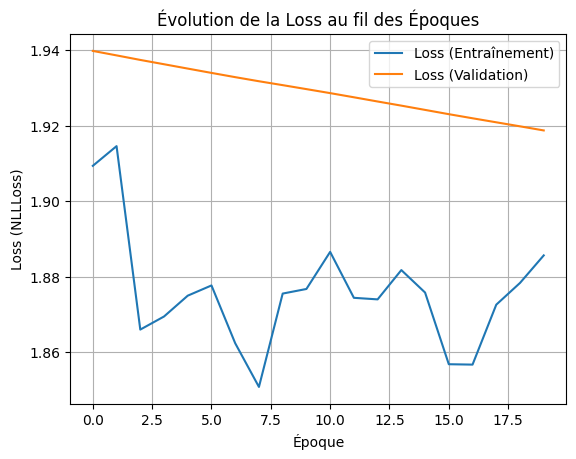

In [16]:
plt.figure()
plt.plot(logger['train_loss'], label='Loss (Entraînement)')
plt.plot(logger['valid_loss'], label='Loss (Validation)')
plt.title('Évolution de la Loss au fil des Époques')
plt.xlabel('Époque')
plt.ylabel('Loss (NLLLoss)')
plt.legend()
plt.grid(True)

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [17]:
modele =torch.load(MODEL_SAVE_PATH,weights_only=False)
modele.eval()

DumbModel(
  (pool): AdaptiveAvgPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=2, out_features=6, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou si vous avancez suffisamment vite plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps, si vous le souhaitez vous pouvez tenter de mettre en place des stratégies autour de l'utilisation des données d'entraînement pour améliorer vos résultats. Si vous cherchez à mettre en place de l'augmentation de données vous pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

In [18]:
class MyCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(MyCNN, self).__init__()

        """Extraction caracteristique"""
        # Conv -> BatchNorm (Astuce) -> ReLU (Non-linearity) -> MaxPool

        # Bloc 1 : Entrée: [B, 2, 2048] -> Sortie: [B, 16, 1024]
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=7, padding=3) # padding = (kernel_size - 1) / 2
        self.bn1 = nn.BatchNorm1d(16) # Batch normalization
        self.pool1 = nn.MaxPool1d(2)  # Réduit les donnees par 2

        # Bloc 2 : Sortie: [B, 32, 512]
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        # Bloc 3 : Sortie: [B, 64, 256]
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)

        """Classificateur"""
        self.global_pool = nn.AdaptiveAvgPool1d(1) # Sortie: [B, 64, 1]

        self.flatten = nn.Flatten() # Sortie: [B, 64]

        self.fc1 = nn.Linear(in_features=64, out_features=32)

        self.fc2 = nn.Linear(in_features=32, out_features=num_classes)

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # x: [Batch size, channel sizes = 2, L]

        """Feature extraction"""
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        # x: [B, 16, 1024]

        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        # x: [B, 32, 512]

        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        # x: [B, 64, 256]

        """classification"""
        x = self.global_pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)

        output = self.log_softmax(x)

        return output

In [19]:
# Définir les hyperparamètres
N_CHANNELS = 2
N_CLASSES = 6
BATCH_SIZE = 64
N_ITERS = 20
TRAIN_FILE = './train.hdf5'
VALID_FILE = './validation.hdf5'
MODEL_SAVE_PATH = './model_weights.pth'

device = 'cuda'

# Preparation des donnees
train_dataset = MyDataset(TRAIN_FILE)
valid_dataset = MyDataset(VALID_FILE)
n_train = len(train_dataset)
n_valid = len(valid_dataset)
# Créer les DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset créé : {n_train} échantillons d'entraînement, {n_valid} échantillons de validation.")


model = MyCNN(in_channels=N_CHANNELS, num_classes=N_CLASSES)

loss_fn = nn.NLLLoss() # Utiliser NLLLoss car le modèle sort un log-proba

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = N_ITERS

chemin_vers_sauvegarde_model = MODEL_SAVE_PATH

model.to(device)

# Logger
logger = {'train_loss': [],'valid_loss': []}

print(f"Début de l'entraînement pour {n_epochs} epochs...")

# Entrainement !

for epoch in range(n_epochs):

    model.train()
    current_train_loss = 0.0

    for batch_x, batch_y, snr in dataloader_train:

        """Given code : Training """
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)

        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()

        optimizer.step()

        """Update logger"""
        current_train_loss += l.item()

    # Average Loss of the iteration
    avg_train_loss = current_train_loss / len(dataloader_train)
    logger['train_loss'].append(avg_train_loss)

    model.eval()
    current_valid_loss = 0.0

    """Given code : Validation phase"""
    with torch.no_grad():
        for batch_x, batch_y, snr in dataloader_valid:

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)

            """Update logger"""
            l_val = loss_fn(batch_y_predicted, batch_y)
            current_valid_loss += l_val.item()

    # Average Loss of the iteration
    avg_valid_loss = current_valid_loss / len(dataloader_valid)
    logger['valid_loss'].append(avg_valid_loss)


    print(f"Epoch {epoch}/{n_epochs} - Train AVG Loss: {avg_train_loss:.4f} - Valid AVG Loss: {avg_valid_loss:.4f}")

torch.save(model, MODEL_SAVE_PATH)

Dataset créé : 30000 échantillons d'entraînement, 10000 échantillons de validation.
Début de l'entraînement pour 20 epochs...
Epoch 0/20 - Train AVG Loss: 1.1152 - Valid AVG Loss: 1.2890
Epoch 1/20 - Train AVG Loss: 0.7384 - Valid AVG Loss: 0.6804
Epoch 2/20 - Train AVG Loss: 0.6431 - Valid AVG Loss: 0.7738
Epoch 3/20 - Train AVG Loss: 0.5925 - Valid AVG Loss: 0.6339
Epoch 4/20 - Train AVG Loss: 0.5443 - Valid AVG Loss: 0.5551
Epoch 5/20 - Train AVG Loss: 0.5243 - Valid AVG Loss: 0.4925
Epoch 6/20 - Train AVG Loss: 0.5034 - Valid AVG Loss: 0.4869
Epoch 7/20 - Train AVG Loss: 0.4969 - Valid AVG Loss: 1.1488
Epoch 8/20 - Train AVG Loss: 0.4871 - Valid AVG Loss: 0.4729
Epoch 9/20 - Train AVG Loss: 0.4807 - Valid AVG Loss: 0.8226
Epoch 10/20 - Train AVG Loss: 0.4747 - Valid AVG Loss: 0.6402
Epoch 11/20 - Train AVG Loss: 0.4700 - Valid AVG Loss: 0.4876
Epoch 12/20 - Train AVG Loss: 0.4614 - Valid AVG Loss: 0.4958
Epoch 13/20 - Train AVG Loss: 0.4613 - Valid AVG Loss: 0.7513
Epoch 14/20 - Tr

# Final Neural Network : Using RNN

In [38]:
def add_noise(x, snr_db):
    sig_power = x.pow(2).mean()
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = sig_power / snr_linear
    noise = torch.randn_like(x) * torch.sqrt(noise_power)
    return x + noise


def my_collate_fn(batch):
    xs, ys, snrs = zip(*batch)

    xs_aug = []
    new_snrs = []

    for x, snr in zip(xs, snrs):
        # x = x.float()
        # snr = float(snr)
        delta = torch.empty(1).uniform_(-5.0, 5.0).item()
        target_snr = snr + delta

        x_noisy = add_noise(x, target_snr)
        xs_aug.append(x_noisy)
        new_snrs.append(target_snr)

    batch_x = torch.stack(xs_aug, dim=0)                     # [B, C, T]
    batch_y = torch.tensor(ys, dtype=torch.long)             # [B]
    batch_snr = torch.tensor(new_snrs, dtype=torch.float32)  # [B]

    return batch_x, batch_y, batch_snr

class MyGRU(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_size=64, num_layers=3):
        super(MyGRU, self).__init__()

        # GRU
        # input_size = 2 (IQ)
        # hidden_size = 32 (GRU )
        self.gru = nn.GRU(
            input_size=in_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Classification (bidirections)
        self.fc = nn.Linear(in_features=hidden_size*2, out_features=num_classes)

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # x init: [Batch, C=2, T=2048]
        # change shape : [Batch, T=2048, C=2]
        x_rnn = x.transpose(1, 2)

        # using gru
        # output: each output [B, T, hidden_size]
        # hn: final hiddden state [num_layers, B, hidden_size]
        output, hn = self.gru(x_rnn)

        # hn[-1] get the final state : [B, hidden_size]
        h_forward = hn[-2, :, :]
        h_backward = hn[-1, :, :]
        final_state = torch.cat([h_forward, h_backward], dim=1)

        # classification
        x = self.fc(final_state)
        output = self.log_softmax(x)

        return output

class MyLSTM(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_size=64, num_layers=3):
        super(MyLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(in_features=hidden_size*2, out_features=num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x_rnn = x.transpose(1, 2)
        output, (hn,_) = self.lstm(x_rnn)
        h_forward = hn[-2, :, :]
        h_backward = hn[-1, :, :]
        final_state = torch.cat([h_forward, h_backward], dim=1)

        x = self.fc(final_state)
        output = self.log_softmax(x)

        return output

class MyCNNGRU(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_size=64, num_layers=3):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=7, padding=3),
            nn.ReLU()
        )

        gru_input_size = 16

        self.gru = nn.GRU(
            input_size=gru_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv(x)
        x_rnn = x.transpose(1, 2)

        output, hn = self.gru(x_rnn)
        h_forward = hn[-2]
        h_backward = hn[-1]
        final_state = torch.cat([h_forward, h_backward], dim=1)
        x = self.fc(final_state)
        return self.log_softmax(x)


In [39]:
# Définir les hyperparamètres
N_CHANNELS = 2
N_CLASSES = 6
BATCH_SIZE = 64
N_ITERS = 20
TRAIN_FILE = './train.hdf5'
VALID_FILE = './validation.hdf5'
MODEL_SAVE_PATH = './model_weights_RNN.pth'

device = 'cuda'

# Preparation des donnees
train_dataset = MyDataset(TRAIN_FILE)
valid_dataset = MyDataset(VALID_FILE)
n_train = len(train_dataset)
n_valid = len(valid_dataset)
# Créer les DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #collate_fn=my_collate_fn
dataloader_valid = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset créé : {n_train} échantillons d'entraînement, {n_valid} échantillons de validation.")


model = MyGRU(in_channels=N_CHANNELS, num_classes=N_CLASSES)

loss_fn = nn.NLLLoss() # Utiliser NLLLoss car le modèle sort un log-proba

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = N_ITERS

chemin_vers_sauvegarde_model = MODEL_SAVE_PATH

model.to(device)

# Logger
logger = {'train_loss': [],'valid_loss': []}

print(f"Début de l'entraînement pour {n_epochs} epochs...")

# Entrainement !

for epoch in range(n_epochs):

    model.train()
    current_train_loss = 0.0

    for batch_x, batch_y, snr in dataloader_train:

        """Given code : Training """
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)

        l = loss_fn(batch_y_predicted, batch_y)

        l.backward()

        optimizer.step()

        """Update logger"""
        current_train_loss += l.item()

    # Average Loss of the iteration
    avg_train_loss = current_train_loss / len(dataloader_train)
    logger['train_loss'].append(avg_train_loss)

    model.eval()
    current_valid_loss = 0.0

    """Given code : Validation phase"""
    with torch.no_grad():
        for batch_x, batch_y, snr in dataloader_valid:

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_predicted = model(batch_x)

            """Update logger"""
            l_val = loss_fn(batch_y_predicted, batch_y)
            current_valid_loss += l_val.item()

    # Average Loss of the iteration
    avg_valid_loss = current_valid_loss / len(dataloader_valid)
    logger['valid_loss'].append(avg_valid_loss)


    print(f"Epoch {epoch}/{n_epochs} - Train AVG Loss: {avg_train_loss:.4f} - Valid AVG Loss: {avg_valid_loss:.4f}")

torch.save(model, MODEL_SAVE_PATH)

Dataset créé : 30000 échantillons d'entraînement, 10000 échantillons de validation.
Début de l'entraînement pour 20 epochs...
Epoch 0/20 - Train AVG Loss: 1.7929 - Valid AVG Loss: 1.7856


KeyboardInterrupt: 

## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec.

Rapport de Complexité
- DumbModel : 18 paramètres
- MyModel : 175,878 paramètres
MyModel est ~ 9771 fois plus complexe que le DumbModel.
Chargement de l'ensemble de Test (Validation Set)
Chargement du Modèle Entraîné
Evaluation du modèle sur l'ensemble de test
Évaluation terminée.
Analyse des Performances
Accuracy Globale : 58.919999999999995%


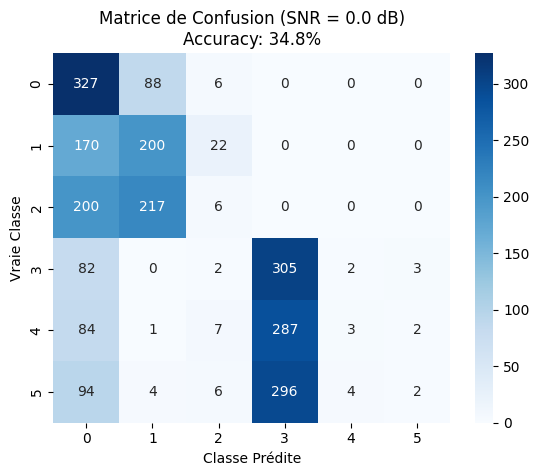

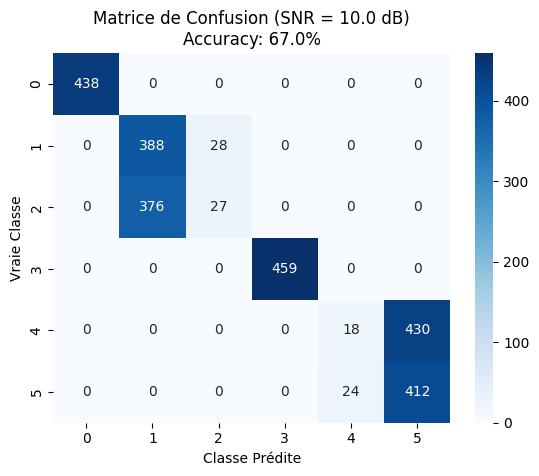

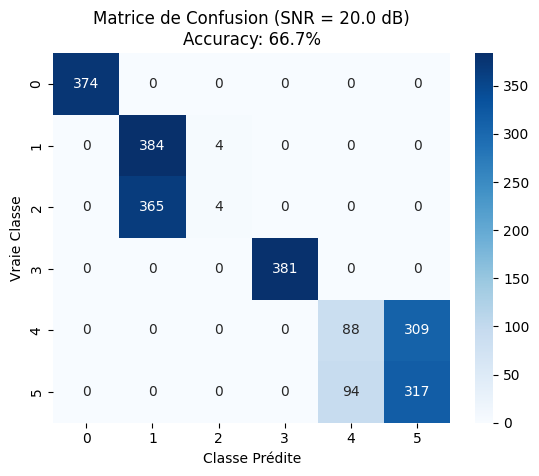

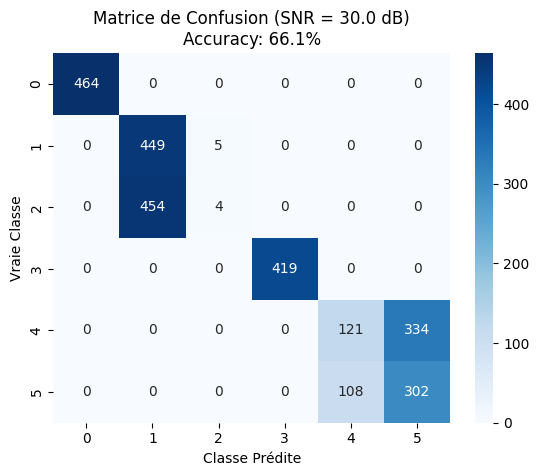

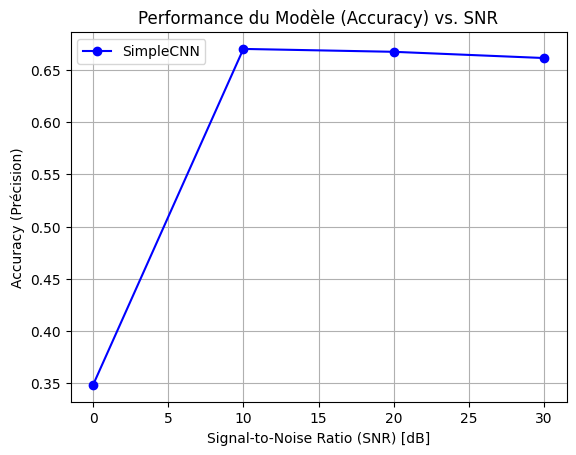

In [37]:
TEST_FILE = './test.hdf5'

# Rapport sur la Complexité
print("Rapport de Complexité")
model_dumb = DumbModel(N_CHANNELS, N_CLASSES)
params_dumb = count_n_param(model_dumb)
print(f"- DumbModel : {params_dumb:,} paramètres")

my_model = MyGRU(N_CHANNELS, N_CLASSES)
params_my = count_n_param(my_model)
print(f"- MyModel : {params_my:,} paramètres")

print(f"MyModel est ~ {params_my / params_dumb:.0f} fois plus complexe que le DumbModel.")

print("Chargement de l'ensemble de Test (Validation Set)")
# Préparation des Données de Test
test_dataset = MyDataset(TEST_FILE)
n_test = len(test_dataset)
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Chargement du Modèle Entraîné
print("Chargement du Modèle Entraîné")

model = torch.load(MODEL_SAVE_PATH,weights_only=False)
model.to(device)
model.eval()

# Évaluation du modèle sur l'ensemble de test
print("Evaluation du modèle sur l'ensemble de test")
all_labels = []
all_predictions = []
all_snrs = []

with torch.no_grad():
    for batch_x, batch_y, batch_snr in dataloader_test:

        batch_x = batch_x.to(device)

        batch_y_predicted_logs = model(batch_x)

        # Convertir les log-probabilités en classe prédite (l'index du max)
        batch_y_pred_class = torch.argmax(batch_y_predicted_logs, dim=1)

        all_labels.append(batch_y.numpy())
        all_predictions.append(batch_y_pred_class.cpu().numpy())
        all_snrs.append(batch_snr.numpy())

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_predictions)
snrs = np.concatenate(all_snrs)

print("Évaluation terminée.")

# Calcul des Métriques et Graphes
print("Analyse des Performances")

# Accuracy Globale
accuracy_global = accuracy_score(y_true, y_pred)
print(f"Accuracy Globale : {accuracy_global * 100}%")

# Analyse par SNR
snr_levels = np.unique(snrs)
snr_levels.sort()
snr_accuracies = []
class_names = [i for i in range(N_CLASSES)]

# Tâche 2: Graphique Accuracy vs. SNR
for snr in snr_levels:
    # Trouver les indices pour ce niveau de SNR
    indices = np.where(snrs == snr)[0]

    if len(indices) > 0:
        # Filtrer les labels et prédictions
        y_true_snr = y_true[indices]
        y_pred_snr = y_pred[indices]

        # Calculer l'accuracy pour ce SNR
        acc_snr = accuracy_score(y_true_snr, y_pred_snr)
        snr_accuracies.append(acc_snr)

        # Matrice de Confusion par SNR
        cm = confusion_matrix(y_true_snr, y_pred_snr, labels=range(N_CLASSES))

        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Matrice de Confusion (SNR = {snr} dB)\nAccuracy: {acc_snr*100:.1f}%')
        plt.ylabel('Vraie Classe')
        plt.xlabel('Classe Prédite')


# Sauvegarder le graphique Accuracy vs. SNR
plt.figure()
plt.plot(snr_levels, snr_accuracies, 'bo-', label='SimpleCNN')
plt.title('Performance du Modèle (Accuracy) vs. SNR')
plt.xlabel('Signal-to-Noise Ratio (SNR) [dB]')
plt.ylabel('Accuracy (Précision)')
plt.grid(True)
plt.legend()
